In [1]:
import time
import pickle

import keras
import keras.backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, LSTM

from ptbdb_cache import load_records

/usr/local/anaconda3/envs/ekg_network/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
from random import shuffle

from keras.utils import Sequence

DATA_DIRECTORY = 'data/cached_records'
MAX_LENGTH = 120012
NUM_CHANNELS = 15


def pad_sequence(sequence, max_len=MAX_LENGTH):
    pad_width = ((0,max_len - sequence.shape[0]), (0, 0))
    
    return np.pad(sequence, pad_width, mode='constant', constant_values=0)


def get_train_dev_test_filenames(fraction=0.15):
    ptbdb_filenames = os.listdir(DATA_DIRECTORY)
    
    shuffle(ptbdb_filenames)
    
    n_holdouts = int(fraction * len(ptbdb_filenames))
    
    train = ptbdb_filenames[:-2 * n_holdouts]
    dev = ptbdb_filenames[-2 * n_holdouts: -n_holdouts]
    test = ptbdb_filenames[-n_holdouts:]
    
    return train, dev, test


class CacheBatchGenerator(Sequence):

    def __init__(self, filenames, batch_size, basedir=DATA_DIRECTORY):
        self.filenames = filenames
        self.batch_size = batch_size
        self.basedir = basedir

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        print('CacheBatchGenerator is getting idx {} of {}'.format(idx, self.__len__()))
        
        batch_filenames = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch = []
        for filename in batch_filenames:
            
            with open(self.basedir + '/' + filename, 'rb') as f:
                data = pickle.load(f)
                
            batch.append(data)
        
        batch_x, batch_y = zip(*batch)
        
        batch_x = [pad_sequence(x) for x in batch_x]
        batch_x = np.stack(batch_x)
        
        
        batch_y = [1 if r == 'Myocardial infarction' else 0 for r in batch_y]
        batch_y = np.array(batch_y).reshape(-1, 1)
        
        return batch_x, batch_y

In [3]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [4]:
def get_random_hyperparameters():
    train_batch, _, _ = get_train_dev_test_filenames()
    
    return {
        'num_hidden_units': np.random.randint(4, 100),
        'batch_size': np.random.randint(10, int(len(train_batch) / 2)),
        'learning_rate': 10**(-4 * np.random.random())
    }

get_random_hyperparameters()

{'batch_size': 21,
 'learning_rate': 0.0011677241060206922,
 'num_hidden_units': 34}

metrics to collect: 
- history (with loss, accuracy, f1 score)
- time to run 10 epochs
- metrics on dev set

In [5]:
def run_model_with_random_hyperparameters(n_epochs=5):
    results = {}
    
    hyperparameters = get_random_hyperparameters()
    
    print('----DEBUG----')
    train_files, dev_files, _ = get_train_dev_test_filenames()
    train_files = train_files[:10]
    dev_files = dev_files[:10]
    
    hyperparameters = {
        'num_hidden_units': 2,
        'batch_size': 10,
        'learning_rate': 0.0001
    }
    
    
    print('trying parameters: {}'.format(hyperparameters))
    results['hyperparameters'] = hyperparameters
    
    batch_size = hyperparameters['batch_size']
    num_hidden_units = hyperparameters['num_hidden_units']
    learning_rate = hyperparameters['learning_rate']
    
    # Build model
    optimizer = Adam(lr=learning_rate)
    
    model = Sequential([
        LSTM(num_hidden_units, input_shape=(MAX_LENGTH, NUM_CHANNELS)),
        Dense(1, activation='sigmoid'),
    ])

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_score])
    
    results['model'] = model
    
    # Train model
    t_before = time.time()
    
    print('----DEBUG----')
#     train_files, dev_files, _ = get_train_dev_test_filenames()
    
    training_batch_generator = CacheBatchGenerator(train_files, batch_size=batch_size)
    dev_batch_generator = CacheBatchGenerator(dev_files, batch_size=min(batch_size, len(dev_files)))
    
    history = model.fit_generator(
        generator=training_batch_generator,
#         steps_per_epoch=(len(train_files) // batch_size),
        validation_data=dev_batch_generator,
#         validation_steps=max(len(dev_files) // batch_size, 1),
        epochs=n_epochs,
        use_multiprocessing=True,
        workers=16,
        max_queue_size=32,
        verbose=2)
    
    results['history'] = history
    
    t_after = time.time()
    total_time = t_after - t_before
    results['training_time'] = total_time
    
    # Test model
    training_batch_generator = CacheBatchGenerator(train_files, batch_size=batch_size)
    dev_batch_generator = CacheBatchGenerator(dev_files, batch_size=min(batch_size, len(dev_files)))
    
    results['train_metrics'] = model.evaluate_generator(training_batch_generator)
    results['dev_metrics'] = model.evaluate_generator(dev_batch_generator)
    
    # Print results
    print('metrics names: ', model.metrics_names)
    print('train_scores: ', results['train_metrics'])
    print('dev_scores: ', results['dev_metrics'])
   
    plt.figure()
    plt.plot(history.history['loss'])
    plt.title(hyperparameters)
    plt.show()
    
    return results





testing model 1 of 5
----DEBUG----
trying parameters: {'num_hidden_units': 2, 'batch_size': 10, 'learning_rate': 0.0001}
----DEBUG----
Epoch 1/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 1 of 10
CacheBatchGenerator is getting idx 4 of 10
CacheBatchGenerator is getting idx 2 of 10
CacheBatchGenerator is getting idx 0 of 10
CacheBatchGenerator is getting idx 3 of 10
CacheBatchGenerator is getting idx 5 of 10
CacheBatchGenerator is getting idx 8 of 10
CacheBatchGenerator is getting idx 7 of 10
CacheBatchGenerator is getting idx 6 of 10
CacheBatchGenerator is getting idx 9 of 10
CacheBatchGenerator is getting idx 0 of 10
CacheBatchGenerator is getting idx 2 of 10
CacheBatchGenerator is getting idx 1 of 10
CacheBatchGenerator is getting idx 3 of 10
CacheBatchGenerator is getting idx 5 of 10
CacheBatchGenerator is getting idx 4 of 10
CacheBatchGenerator is getting idx 7 of 10
CacheBatchGenerator is getting idx 8 of

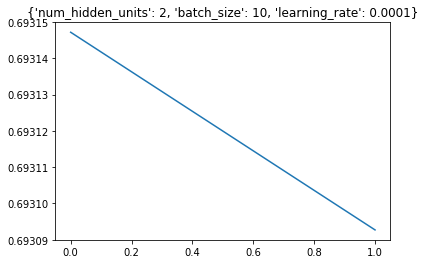


testing model 2 of 5
----DEBUG----
trying parameters: {'num_hidden_units': 2, 'batch_size': 10, 'learning_rate': 0.0001}
----DEBUG----
Epoch 1/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 4 of 10
CacheBatchGenerator is getting idx 5 of 10
CacheBatchGenerator is getting idx 0 of 10
CacheBatchGenerator is getting idx 2 of 10
CacheBatchGenerator is getting idx 3 of 10
CacheBatchGenerator is getting idx 1 of 10
CacheBatchGenerator is getting idx 6 of 10
CacheBatchGenerator is getting idx 7 of 10
CacheBatchGenerator is getting idx 8 of 10
CacheBatchGenerator is getting idx 9 of 10
CacheBatchGenerator is getting idx 1 of 10
CacheBatchGenerator is getting idx 3 of 10
CacheBatchGenerator is getting idx 0 of 10
CacheBatchGenerator is getting idx 4 of 10
CacheBatchGenerator is getting idx 7 of 10
CacheBatchGenerator is getting idx 2 of 10
CacheBatchGenerator is getting idx 6 of 10
CacheBatchGenerator is getting idx 5 of

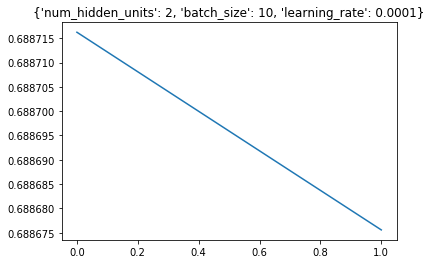


testing model 3 of 5
----DEBUG----
trying parameters: {'num_hidden_units': 2, 'batch_size': 10, 'learning_rate': 0.0001}
----DEBUG----
Epoch 1/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 2 of 10
CacheBatchGenerator is getting idx 0 of 10
CacheBatchGenerator is getting idx 1 of 10
CacheBatchGenerator is getting idx 3 of 10
CacheBatchGenerator is getting idx 6 of 10
CacheBatchGenerator is getting idx 5 of 10
CacheBatchGenerator is getting idx 4 of 10
CacheBatchGenerator is getting idx 7 of 10
CacheBatchGenerator is getting idx 8 of 10
CacheBatchGenerator is getting idx 9 of 10
CacheBatchGenerator is getting idx 5 of 10
CacheBatchGenerator is getting idx 0 of 10
CacheBatchGenerator is getting idx 1 of 10
CacheBatchGenerator is getting idx 3 of 10
CacheBatchGenerator is getting idx 6 of 10
CacheBatchGenerator is getting idx 7 of 10
CacheBatchGenerator is getting idx 8 of 10
CacheBatchGenerator is getting idx 2 of

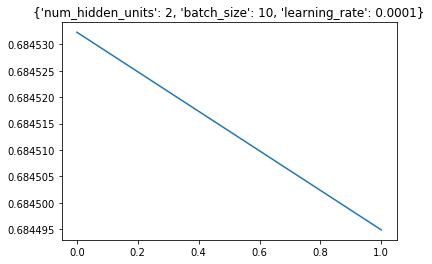


testing model 4 of 5
----DEBUG----
trying parameters: {'num_hidden_units': 2, 'batch_size': 10, 'learning_rate': 0.0001}
----DEBUG----
Epoch 1/2
CacheBatchGenerator is getting idx 0 of 1
Epoch 1/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 10
CacheBatchGenerator is getting idx 1 of 10
CacheBatchGenerator is getting idx 2 of 10
CacheBatchGenerator is getting idx 5 of 10
CacheBatchGenerator is getting idx 4 of 10
CacheBatchGenerator is getting idx 6 of 10
CacheBatchGenerator is getting idx 3 of 10
CacheBatchGenerator is getting idx 7 of 10
CacheBatchGenerator is getting idx 8 of 10
CacheBatchGenerator is getting idx 9 of 10
CacheBatchGenerator is getting idx 1 of 10
CacheBatchGenerator is getting idx 2 of 10
CacheBatchGenerator is getting idx 0 of 10
CacheBatchGenerator is getting idx 3 of 10
CacheBatchGenerator is getting idx 6 of 10
CacheBatchGenerator is getting idx 7 of 10
CacheBatchGenerator is getting idx 8 of 10
CacheBatchGenerator is gettin

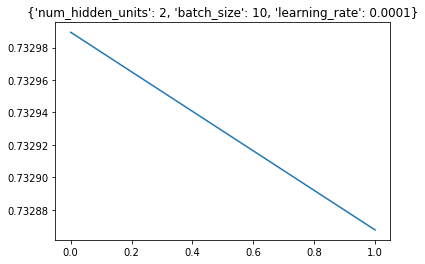


testing model 5 of 5
----DEBUG----
trying parameters: {'num_hidden_units': 2, 'batch_size': 10, 'learning_rate': 0.0001}
----DEBUG----
Epoch 1/2
Epoch 1/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 10
CacheBatchGenerator is getting idx 1 of 10
CacheBatchGenerator is getting idx 2 of 10
CacheBatchGenerator is getting idx 3 of 10
CacheBatchGenerator is getting idx 4 of 10
CacheBatchGenerator is getting idx 5 of 10
CacheBatchGenerator is getting idx 6 of 10
CacheBatchGenerator is getting idx 7 of 10
CacheBatchGenerator is getting idx 9 of 10
CacheBatchGenerator is getting idx 8 of 10
CacheBatchGenerator is getting idx 1 of 10
CacheBatchGenerator is getting idx 2 of 10
CacheBatchGenerator is getting idx 3 of 10
CacheBatchGenerator is getting idx 0 of 10
CacheBatchGenerator is getting idx 4 of 10
CacheBatchGenerator is getting idx 5 of 10
CacheBatchGenerator is getting idx 7 of 10
CacheBatchGenerator is gettin

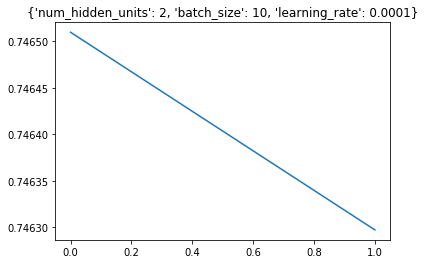

In [6]:
N_MODELS = 5

print('DEBUG: this should be higher')
N_EPOCHS = 2

model_test_results = []
for i in range(N_MODELS):
    print('\ntesting model {} of {}'.format(i + 1, N_MODELS))
    
    try:
        model_result = run_model_with_random_hyperparameters(n_epochs=N_EPOCHS)

        model_test_results.append(model_result)
    except KeyboardInterrupt:
        print('Test Interrupted.')
        break
    
